In [42]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_lr_bnn import MFDNNBNN
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfbml.methods.mf_dnn_bnn import SequentialMFBNN
from mfbml.problems.high_dimension_problems import MengCase1
from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
# fix the random seed for reproducibility
seed = 1996
np.random.seed(seed)
torch.manual_seed(seed)

In [43]:
# define function
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
# hf_samples = lf_samples[::10]  # sample every 5 points
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points
# hf_samples = torch.cat(
#     [torch.tensor([[0.0]]), hf_samples, torch.tensor([[0.93]]), torch.tensor([[0.975,]]), torch.tensor([[1.0]])], dim=0)

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)

In [44]:
# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

# dataset of lf1 and hf
responses_lf1 = {"lf": lf1_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf2 = {"lf": lf2_responses,
                 "hf": hf_responses}
# dataset of lf2 and hf
responses_lf3 = {"lf": lf3_responses,
                 "hf": hf_responses}

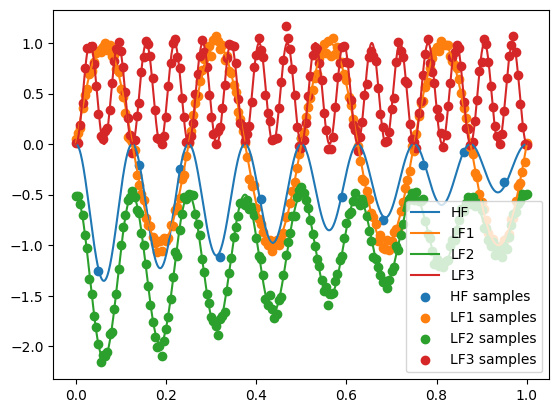

In [45]:
# generate the test points
test_samples = torch.linspace(0, 1, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless, label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless, label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless, label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
plt.legend()
plt.show()

In [46]:
# correlation between HF and LF samples
print("Correlation between HF and LF samples")
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf1_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf2_responses_noiseless.flatten()))
print(pearsonr(test_hf_responses_noiseless.flatten(),
      test_lf3_responses_noiseless.flatten()))

Correlation between HF and LF samples
PearsonRResult(statistic=-0.10188648995412593, pvalue=0.0012469388228371753)
PearsonRResult(statistic=0.9999999999999967, pvalue=0.0)
PearsonRResult(statistic=-0.0017524227898377388, pvalue=0.9558397582437065)


## Configurations for DNN and BNNs


In [47]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 20000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 10000,
}

### train standard BNN using HF data


In [48]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[30, 30],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=20000,
    sample_freq=100,
    burn_in_epochs=10000,
)

epoch:     0/20000
nll_loss: 375.130, prior_loss: 954.253, total: 1329.383
noise: 0.119
epoch:   100/20000
nll_loss: 283.146, prior_loss: 996.123, total: 1279.269
noise: 0.119
epoch:   200/20000
nll_loss: 277.894, prior_loss: 1033.322, total: 1311.216
noise: 0.119
epoch:   300/20000
nll_loss: 277.016, prior_loss: 1064.015, total: 1341.031
noise: 0.119
epoch:   400/20000
nll_loss: 276.978, prior_loss: 1100.059, total: 1377.036
noise: 0.119
epoch:   500/20000
nll_loss: 274.414, prior_loss: 1130.096, total: 1404.510
noise: 0.119
epoch:   600/20000
nll_loss: 271.725, prior_loss: 1156.414, total: 1428.140
noise: 0.119
epoch:   700/20000
nll_loss: 272.089, prior_loss: 1171.686, total: 1443.775
noise: 0.119
epoch:   800/20000
nll_loss: 270.755, prior_loss: 1191.848, total: 1462.603
noise: 0.119
epoch:   900/20000
nll_loss: 260.017, prior_loss: 1210.843, total: 1470.860
noise: 0.119
epoch:  1000/20000
nll_loss: 265.545, prior_loss: 1223.971, total: 1489.517
noise: 0.119
epoch:  1100/20000
nll_

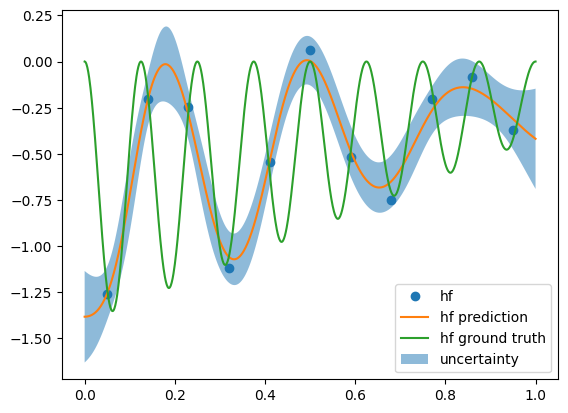

In [49]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")
plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [50]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9608544707298279
epoch:  200 train loss:  0.9606325030326843
epoch:  300 train loss:  0.9603413939476013
epoch:  400 train loss:  0.959889829158783
epoch:  500 train loss:  0.959062933921814
epoch:  600 train loss:  0.9571234583854675
epoch:  700 train loss:  0.9310305118560791
epoch:  800 train loss:  0.8703039884567261
epoch:  900 train loss:  0.7436082363128662
epoch:  1000 train loss:  0.5825821757316589
epoch:  1100 train loss:  0.43527641892433167
epoch:  1200 train loss:  0.21215124428272247
epoch:  1300 train loss:  0.0508321113884449
epoch:  1400 train loss:  0.030569637194275856
epoch:  1500 train loss:  0.020016329362988472
epoch:  1600 train loss:  0.01350446231663227
epoch:  1700 train loss:  0.010213163681328297
epoch:  1800 train loss:  0.008281134068965912
epoch:  1900 train loss:  0.006927217356860638
epoch:  2000 train loss:  0.005931015592068434
epoch:  2100 train loss:  0.005197861231863499
epoch:  

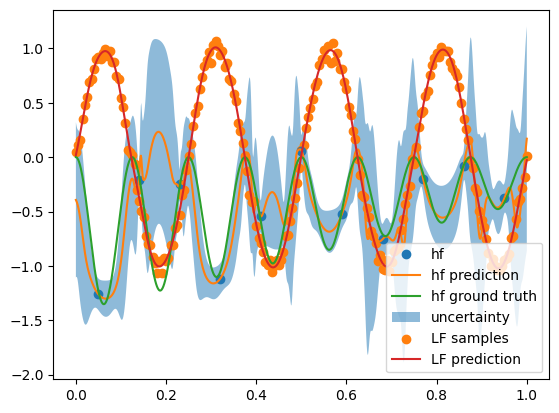

In [51]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [52]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9610694646835327
epoch:  200 train loss:  0.9608117341995239
epoch:  300 train loss:  0.9604997634887695
epoch:  400 train loss:  0.9600328207015991
epoch:  500 train loss:  0.9548587799072266
epoch:  600 train loss:  0.8972390294075012
epoch:  700 train loss:  0.8118836283683777
epoch:  800 train loss:  0.5839525461196899
epoch:  900 train loss:  0.29765668511390686
epoch:  1000 train loss:  0.07317616045475006
epoch:  1100 train loss:  0.04692091792821884
epoch:  1200 train loss:  0.03943966329097748
epoch:  1300 train loss:  0.03379073366522789
epoch:  1400 train loss:  0.027072731405496597
epoch:  1500 train loss:  0.021952588111162186
epoch:  1600 train loss:  0.019230874255299568
epoch:  1700 train loss:  0.017235150560736656
epoch:  1800 train loss:  0.015258443541824818
epoch:  1900 train loss:  0.013173390179872513
epoch:  2000 train loss:  0.011103352531790733
epoch:  2100 train loss:  0.009289360605180264
ep

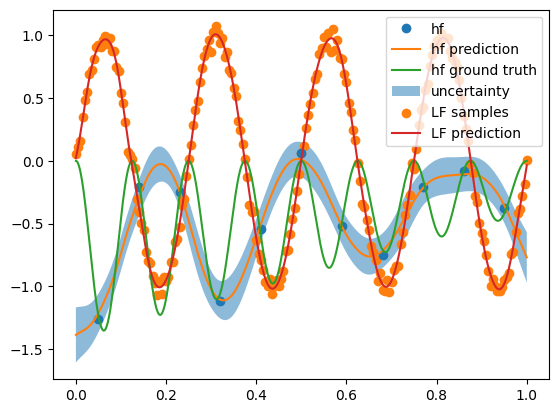

In [53]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

In [54]:
# mf-dnn-bnn with different orders
mfdnnbnn_lf1_order_2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure={
        "in_features": 1,
        "hidden_features": [50, 50],
        "out_features": 1,
        "activation": "Tanh",
        "lr": 0.001,
        "sigma": 0.05,
    },
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)

# train the model
mfdnnbnn_lf1_order_2.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config={
        "num_epochs": 20000,
        "sample_freq": 100,
        "print_info": True,
        "burn_in_epochs": 10000,
    },
)

No data split: use all data for training
epoch:  100 train loss:  0.9613711833953857
epoch:  200 train loss:  0.9610560536384583
epoch:  300 train loss:  0.9607085585594177
epoch:  400 train loss:  0.9602270722389221
epoch:  500 train loss:  0.9591172337532043
epoch:  600 train loss:  0.9497576951980591
epoch:  700 train loss:  0.88554847240448
epoch:  800 train loss:  0.7665613293647766
epoch:  900 train loss:  0.5472663044929504
epoch:  1000 train loss:  0.2669025659561157
epoch:  1100 train loss:  0.10679683089256287
epoch:  1200 train loss:  0.064149409532547
epoch:  1300 train loss:  0.050659190863370895
epoch:  1400 train loss:  0.041935451328754425
epoch:  1500 train loss:  0.03122979775071144
epoch:  1600 train loss:  0.02151358872652054
epoch:  1700 train loss:  0.015230865217745304
epoch:  1800 train loss:  0.010816427879035473
epoch:  1900 train loss:  0.007944067008793354
epoch:  2000 train loss:  0.0063467565923929214
epoch:  2100 train loss:  0.005465583875775337
epoch:  

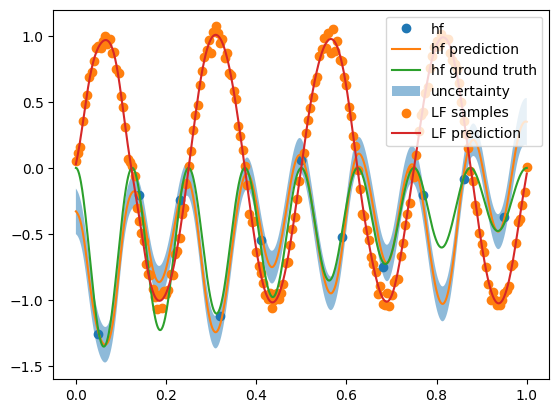

In [55]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_order_2_hy,
    mfdnnbnn_lf1_order_2_epistemic,
    mfdnnbnn_lf1_order_2_total_unc,
    mfdnnbnn_lf1_order_2_aleatoric,
) = mfdnnbnn_lf1_order_2.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_order_2_y = mfdnnbnn_lf1_order_2.predict_lf(
    x=test_samples, output_format="numpy")
mfdnnbnn_lf1_order_2_y_scale = (
    mfdnnbnn_lf1_order_2_y - hf_responses_mean)/hf_responses_std
transfered_ly = mfdnnbnn_lf1_order_2_y_scale**2 * \
    mfdnnbnn_lf1_order_2.beta[2] + mfdnnbnn_lf1_order_2_y_scale * \
    mfdnnbnn_lf1_order_2.beta[1] + mfdnnbnn_lf1_order_2.beta[0]

# hf_model predict
hf_y, _, _, _ = mfdnnbnn_lf1_order_2.hf_model.predict(x=test_samples)
# scale the prediction
hf_y = (transfered_ly+hf_y)*hf_responses_std + hf_responses_mean
# scale
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot transfered lf predictions
# ax.plot(test_samples.numpy(), transfered_ly,
#         label="Transfered LF prediction")
# plot hf predictions
# ax.plot(test_samples.numpy(), hf_y, label="HF prediction 111")
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(),
        mfdnnbnn_lf1_order_2_y,
        label="LF prediction")
ax.legend()
plt.show()

In [56]:
mfdnnbnn_lf1_order_2.beta

array([ 0.00758876, -0.21651334, -0.9327748 ])

## mf models for the second dataset

In [57]:
# sequential mf-bnn
smf_bnn_lf2 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8509591817855835
epoch:  200 train loss:  0.8507910370826721
epoch:  300 train loss:  0.8506827354431152
epoch:  400 train loss:  0.8506140112876892
epoch:  500 train loss:  0.8505628705024719
epoch:  600 train loss:  0.8505113124847412
epoch:  700 train loss:  0.8504465818405151
epoch:  800 train loss:  0.8503542542457581
epoch:  900 train loss:  0.8502010703086853
epoch:  1000 train loss:  0.849901556968689
epoch:  1100 train loss:  0.8491944074630737
epoch:  1200 train loss:  0.8463947772979736
epoch:  1300 train loss:  0.8261048197746277
epoch:  1400 train loss:  0.7599307894706726
epoch:  1500 train loss:  0.6975355744361877
epoch:  1600 train loss:  0.6641727089881897
epoch:  1700 train loss:  0.6000232100486755
epoch:  1800 train loss:  0.5287594795227051
epoch:  1900 train loss:  0.4906080663204193
epoch:  2000 train loss:  0.47915565967559814
epoch:  2100 train loss:  0.4667501449584961
epoch:  2200 train loss

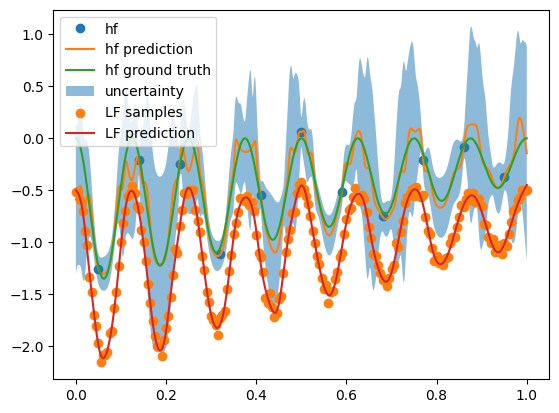

In [58]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf2_hy,
    smf_bnn_lf2_epistemic,
    smf_bnn_lf2_total_unc,
    smf_bnn_lf2_aleatoric,
) = smf_bnn_lf2.predict(x=test_samples)
# get lf predictions
smf_bnn_lf2_y = smf_bnn_lf2.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [59]:
# create the MFDNNBNN object
mfdnnbnn_lf2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8508942723274231
epoch:  200 train loss:  0.8506965637207031
epoch:  300 train loss:  0.8505812287330627
epoch:  400 train loss:  0.8505007028579712
epoch:  500 train loss:  0.8504139184951782
epoch:  600 train loss:  0.8502925038337708
epoch:  700 train loss:  0.8501114249229431
epoch:  800 train loss:  0.8498326539993286
epoch:  900 train loss:  0.8493740558624268
epoch:  1000 train loss:  0.8485804796218872
epoch:  1100 train loss:  0.8470640182495117
epoch:  1200 train loss:  0.8422837853431702
epoch:  1300 train loss:  0.8213610053062439
epoch:  1400 train loss:  0.7712361216545105
epoch:  1500 train loss:  0.7141706347465515
epoch:  1600 train loss:  0.6815226674079895
epoch:  1700 train loss:  0.6599465012550354
epoch:  1800 train loss:  0.5743317604064941
epoch:  1900 train loss:  0.4880601465702057
epoch:  2000 train loss:  0.43481558561325073
epoch:  2100 train loss:  0.41370895504951477
epoch:  2200 train lo

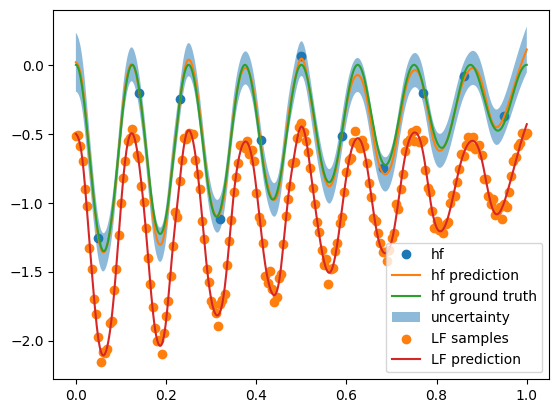

In [60]:
(
    hy_proposed_lf2,
    epistemic_proposed_lf2,
    total_unc_proposed_lf2,
    aleatoric_proposed_lf2,
) = mfdnnbnn_lf2.predict(x=test_samples)
# lf prediction
lf2_y_proposed = mfdnnbnn_lf2.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf2_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

## for datset 3

In [61]:
# sequential mf-bnn
smf_bnn_lf3 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.994816780090332
epoch:  200 train loss:  0.9947866797447205
epoch:  300 train loss:  0.994758129119873
epoch:  400 train loss:  0.9947352409362793
epoch:  500 train loss:  0.9947179555892944
epoch:  600 train loss:  0.9947024583816528
epoch:  700 train loss:  0.9946855306625366
epoch:  800 train loss:  0.9946632981300354
epoch:  900 train loss:  0.9946300387382507
epoch:  1000 train loss:  0.9945744872093201
epoch:  1100 train loss:  0.9944777488708496
epoch:  1200 train loss:  0.9943370223045349
epoch:  1300 train loss:  0.9942082762718201
epoch:  1400 train loss:  0.9941035509109497
epoch:  1500 train loss:  0.9939853549003601
epoch:  1600 train loss:  0.9938198924064636
epoch:  1700 train loss:  0.9935575127601624
epoch:  1800 train loss:  0.9931065440177917
epoch:  1900 train loss:  0.9923108816146851
epoch:  2000 train loss:  0.9910972118377686
epoch:  2100 train loss:  0.9895241260528564
epoch:  2200 train loss: 

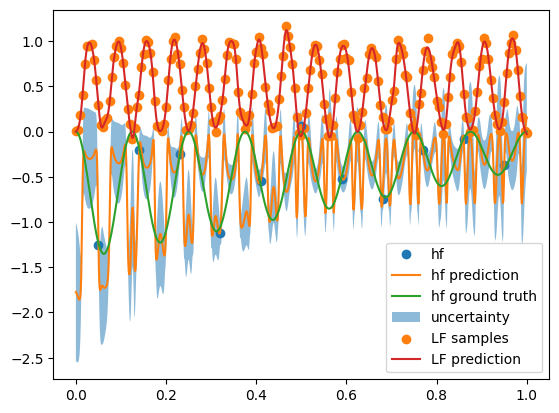

In [62]:
# plot
(
    smf_bnn_lf3_hy,
    smf_bnn_lf3_epistemic,
    smf_bnn_lf3_total_unc,
    smf_bnn_lf3_aleatoric,
) = smf_bnn_lf3.predict(x=test_samples)
# get lf predictions
smf_bnn_lf3_y = smf_bnn_lf3.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [63]:
# create the MFDNNBNN object
mfdnnbnn_lf3 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.995066225528717
epoch:  200 train loss:  0.9949823617935181
epoch:  300 train loss:  0.9948965907096863
epoch:  400 train loss:  0.9948225021362305
epoch:  500 train loss:  0.9947729110717773
epoch:  600 train loss:  0.9947450757026672
epoch:  700 train loss:  0.9947255253791809
epoch:  800 train loss:  0.9947053790092468
epoch:  900 train loss:  0.994676411151886
epoch:  1000 train loss:  0.994615375995636
epoch:  1100 train loss:  0.9944875240325928
epoch:  1200 train loss:  0.9943515658378601
epoch:  1300 train loss:  0.9942917227745056
epoch:  1400 train loss:  0.9942692518234253
epoch:  1500 train loss:  0.9942526817321777
epoch:  1600 train loss:  0.9942348599433899
epoch:  1700 train loss:  0.9942135214805603
epoch:  1800 train loss:  0.9941860437393188
epoch:  1900 train loss:  0.9941480159759521
epoch:  2000 train loss:  0.9940923452377319
epoch:  2100 train loss:  0.9940016865730286
epoch:  2200 train loss:  

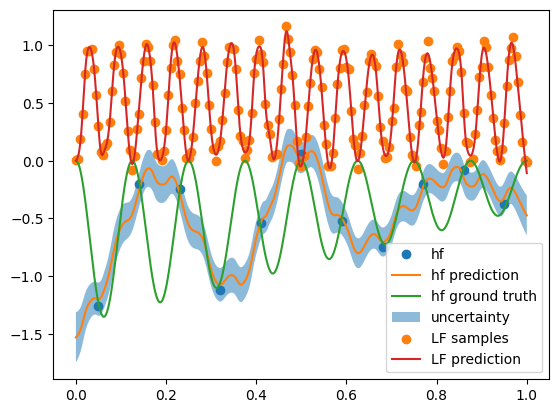

In [64]:
# predict
(
    hy_proposed_lf3,
    epistemic_proposed_lf3,
    total_unc_proposed_lf3,
    aleatoric_proposed_lf3,
) = mfdnnbnn_lf3.predict(x=test_samples)
# lf prediction
lf3_y_proposed = mfdnnbnn_lf3.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf3_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [65]:
# print the beta values
print("Beta values")
print(mfdnnbnn_lf1.beta)
print(mfdnnbnn_lf1_order_2.beta)
print(mfdnnbnn_lf2.beta)
print(mfdnnbnn_lf3.beta)

Beta values
[-0.4770564  -0.18677444]
[ 0.00758876 -0.21651334 -0.9327748 ]
[0.42636777 0.85135377]
[-0.55184476  0.16252376]


In [66]:
# evaluate the models on the accuracy metrics
# bnn model
# calculate the mse
import pandas as pd
bnn_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), bnn_y, bnn_total_unc)
bnn_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), bnn_y)
# print the results
print("BNN model")
print(f"Normalized RMSE: {bnn_mse}")
print(f"Normalized MAE: {bnn_nmae}")
print(f"Normalized Log Likelihood: {bnn_nll}")
print(f"R2: {bnn_r2}")

# sequential mf-bnn on lf1
# calculate the mse
smf_bnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy, smf_bnn_lf1_total_unc)
smf_bnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
# print the results
print("Sequential MF-BNN on LF1")
print(f"Normalized RMSE: {smf_bnn_lf1_mse}")
print(f"Normalized MAE: {smf_bnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf1_nll}")
print(f"R2: {smf_bnn_lf1_r2}")

# mf-dnn-bnn on lf1
# calculate the mse
mfdnnbnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy, mfdnnbnn_lf1_total_unc)
mfdnnbnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
# print the results
print("MF-DNN-BNN on LF1")
print(f"Normalized RMSE: {mfdnnbnn_lf1_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_nll}")

# mf-dnn-bnn on lf1 with order 2
# calculate the mse
mfdnnbnn_lf1_order_2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy, mfdnnbnn_lf1_order_2_total_unc)
mfdnnbnn_lf1_order_2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
# print the results
print("MF-DNN-BNN on LF1 with order 2")
print(f"Normalized RMSE: {mfdnnbnn_lf1_order_2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_order_2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_order_2_nll}")
print(f"R2: {mfdnnbnn_lf1_order_2_r2}")


# sequential mf-bnn on lf2
# calculate the mse
smf_bnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy, smf_bnn_lf2_total_unc)
smf_bnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
# print the results
print("Sequential MF-BNN on LF2")
print(f"Normalized RMSE: {smf_bnn_lf2_mse}")
print(f"Normalized MAE: {smf_bnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf2_nll}")
print(f"R2: {smf_bnn_lf2_r2}")

# mf-dnn-bnn on lf2
# calculate the mse
mfdnnbnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2, total_unc_proposed_lf2)
mfdnnbnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
# print the results
print("MF-DNN-BNN on LF2")
print(f"Normalized RMSE: {mfdnnbnn_lf2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf2_nll}")
print(f"R2: {mfdnnbnn_lf2_r2}")

# sequential mf-bnn on lf3
# calculate the mse
smf_bnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy, smf_bnn_lf3_total_unc)
smf_bnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)

# print the results
print("Sequential MF-BNN on LF3")
print(f"Normalized RMSE: {smf_bnn_lf3_mse}")
print(f"Normalized MAE: {smf_bnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf3_nll}")
print(f"R2: {smf_bnn_lf3_r2}")

# mf-dnn-bnn on lf3
# calculate the mse
mfdnnbnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3, total_unc_proposed_lf3)
mfdnnbnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
# print the results
print("MF-DNN-BNN on LF3")
print(f"Normalized RMSE: {mfdnnbnn_lf3_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf3_nll}")
print(f"R2: {mfdnnbnn_lf3_r2}")

# save the results in pandas dataframe
results = {
    "Model": ["BNN", "Sequential MF-BNN LF1", "MF-DNN-BNN LF1",
              "MF-DNN-BNN LF1 Order 2", "Sequential MF-BNN LF2",
              "MF-DNN-BNN LF2", "Sequential MF-BNN LF3", "MF-DNN-BNN LF3"],
    "Normalized RMSE": [bnn_mse, smf_bnn_lf1_mse, mfdnnbnn_lf1_mse,
                        mfdnnbnn_lf1_order_2_mse, smf_bnn_lf2_mse,
                        mfdnnbnn_lf2_mse, smf_bnn_lf3_mse, mfdnnbnn_lf3_mse],
    "Normalized MAE": [bnn_nmae, smf_bnn_lf1_nmae, mfdnnbnn_lf1_nmae,
                       mfdnnbnn_lf1_order_2_nmae, smf_bnn_lf2_nmae,
                       mfdnnbnn_lf2_nmae, smf_bnn_lf3_nmae, mfdnnbnn_lf3_nmae],
    "Normalized Log Likelihood": [bnn_nll, smf_bnn_lf1_nll, mfdnnbnn_lf1_nll,
                                  mfdnnbnn_lf1_order_2_nll, smf_bnn_lf2_nll,
                                  mfdnnbnn_lf2_nll, smf_bnn_lf3_nll, mfdnnbnn_lf3_nll],
    "R2": [bnn_r2, smf_bnn_lf1_r2, mfdnnbnn_lf1_r2,
           mfdnnbnn_lf1_order_2_r2, smf_bnn_lf2_r2,
           mfdnnbnn_lf2_r2, smf_bnn_lf3_r2, mfdnnbnn_lf3_r2],
}
results_df = pd.DataFrame(results)
print(results_df)
# save the results
results_df.to_csv("results.csv", index=False)

BNN model
Normalized RMSE: 1.0316038131713867
Normalized MAE: 3.027486562728882
Normalized Log Likelihood: -15.100417137145996
R2: -0.6386730867511892
Sequential MF-BNN on LF1
Normalized RMSE: 0.8139383792877197
Normalized MAE: 3.1886541843414307
Normalized Log Likelihood: -0.11960774660110474
R2: -0.020116031907445153
MF-DNN-BNN on LF1
Normalized RMSE: 1.061791181564331
Normalized MAE: 3.0365796089172363
Normalized Log Likelihood: -18.1506404876709
MF-DNN-BNN on LF1 with order 2
Normalized RMSE: 0.3981579840183258
Normalized MAE: 0.9426324963569641
Normalized Log Likelihood: -2.002784013748169
R2: 0.7558946613925842
Sequential MF-BNN on LF2
Normalized RMSE: 0.26402032375335693
Normalized MAE: 1.291733980178833
Normalized Log Likelihood: 0.8345111012458801
R2: 0.8926650390799037
MF-DNN-BNN on LF2
Normalized RMSE: 0.08338930457830429
Normalized MAE: 0.24373576045036316
Normalized Log Likelihood: 1.6556730270385742
R2: 0.9892925218474218
Sequential MF-BNN on LF3
Normalized RMSE: 1.090122

In [69]:
results_df

,Model,Normalized RMSE,Normalized MAE,Normalized Log Likelihood,R2
0,BNN,1.031604,3.027487,-15.100417,-0.638673
1,Sequential MF-BNN LF1,0.813938,3.188654,-0.119608,-0.020116
2,MF-DNN-BNN LF1,1.061791,3.036580,-18.150640,-0.735980
3,MF-DNN-BNN LF1 Order 2,0.398158,0.942632,-2.002784,0.755895
4,Sequential MF-BNN LF2,0.264020,1.291734,0.834511,0.892665
5,MF-DNN-BNN LF2,0.083389,0.243736,1.655673,0.989293
6,Sequential MF-BNN LF3,1.090123,3.977137,-5.532636,-0.829858
7,MF-DNN-BNN LF3,1.044826,3.351634,-17.973713,-0.680949


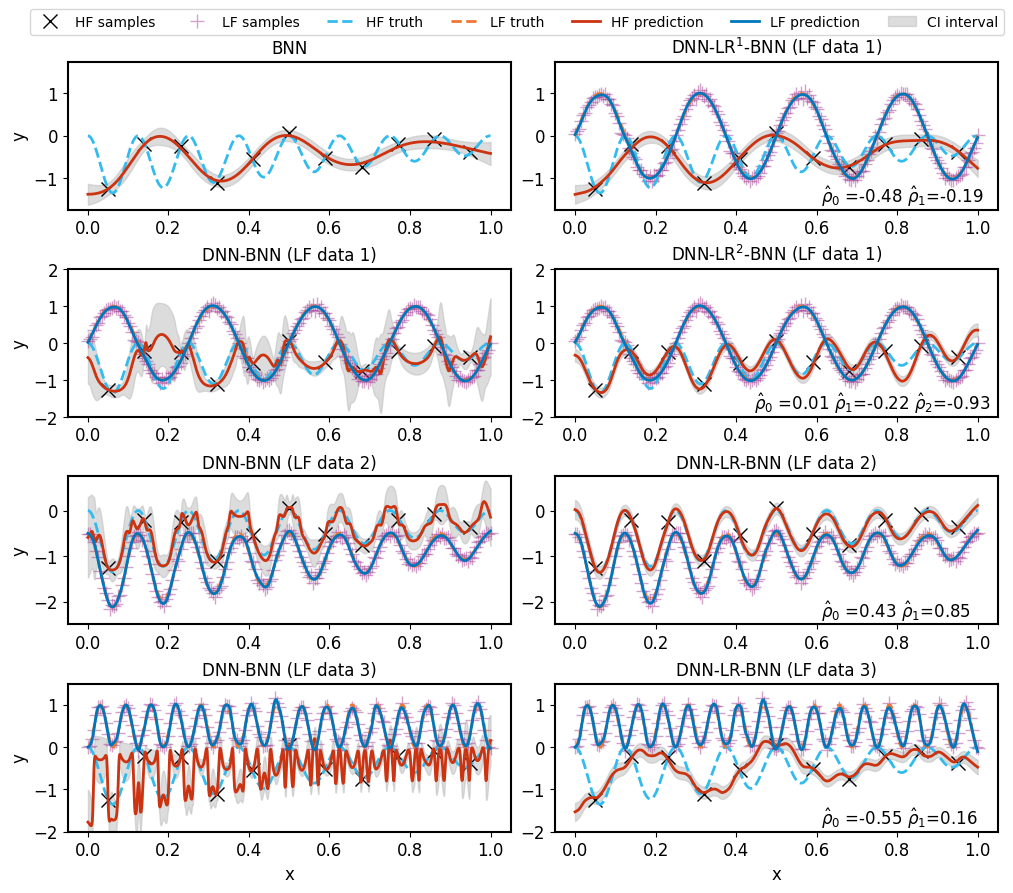

In [68]:
# plot the prediction of the models into one figure where the first row is the
# prediction of bnn (with one subfigure), and the second row is the prediction of sequential mf-bnn mf-dnn-bnn on lf1 (with two subfigures)
# the third row is the prediction of sequential mf-bnn mf-dnn-bnn on lf2 (with two subfigures)
# the forth row is the prediction of sequential mf-bnn mf-dnn-bnn on lf3  (with two subfigures)
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
# plot the prediction of bnn
axs[0, 0].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10, label="HF samples")
axs[0, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[0, 0].plot(test_samples.numpy(),
               bnn_y,
               "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)

axs[0, 0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[0, 0].legend()
axs[0, 0].set_title("BNN")

# plot the prediction of mf-dnn-bnn on lf1 with order1
axs[0, 1].plot(hf_samples, hf_responses, "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[0, 1].plot(lf_samples, lf1_responses,
               "+", color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[0, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# plot the lf truth
axs[0, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[0, 1].plot(test_samples.numpy(),
               mfdnnbnn_lf1_hy,  "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)
axs[0, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_order_2_y,
    "-", color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
axs[0, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[0, 1].legend()
axs[0, 1].set_title(r"DNN-LR$^1$-BNN (LF data 1)")


# plot the prediction of sequential mf-bnn on lf1
axs[1, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[1, 0].plot(lf_samples, lf1_responses,  '+',
               color="#AA4499",
               linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[1, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[1, 0].plot(test_samples.numpy(), smf_bnn_lf1_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[1, 0].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
#
axs[1, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,

    label="LF prediction"
)
axs[1, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 0].legend()
axs[1, 0].set_title("DNN-BNN (LF data 1)")


# plot the prediction of mf-dnn-bnn on lf1
axs[1, 1].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10,
               label="HF samples")
axs[1, 1].plot(lf_samples, lf1_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[1, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# with lf order 2
axs[1, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[1, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[1, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# with lf order 2
axs[1, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 1].legend()
axs[1, 1].set_title(r"DNN-LR$^2$-BNN (LF data 1)")
# plot the prediction of sequential mf-bnn on lf2
axs[2, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[2, 0].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)


axs[2, 0].plot(test_samples.numpy(), smf_bnn_lf2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[2, 0].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[2, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[2, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf2_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[2, 0].legend()
axs[2, 0].set_title("DNN-BNN (LF data 2)")

# plot the prediction of mf-dnn-bnn on lf2
axs[2, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[2, 1].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[2, 1].plot(test_samples.numpy(), hy_proposed_lf2,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[2, 1].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
# plot the lf prediction
axs[2, 1].plot(
    test_samples.numpy(),
    lf2_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# plot the uncertainty
axs[2, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval"
)

# axs[2, 1].legend()
axs[2, 1].set_title("DNN-LR-BNN (LF data 2)")
# plot the prediction of sequential mf-bnn on lf3
axs[3, 0].plot(hf_samples, hf_responses,
               'kx', linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 0].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 0].plot(test_samples.numpy(), smf_bnn_lf3_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")

# plot the lf truth
axs[3, 0].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[3, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"

)

axs[3, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[3, 0].legend()
axs[3, 0].set_title("DNN-BNN (LF data 3)")

# plot the prediction of mf-dnn-bnn on lf3
axs[3, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 1].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 1].plot(test_samples.numpy(), hy_proposed_lf3,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")


# plot the lf truth
axs[3, 1].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
axs[3, 1].plot(
    test_samples.numpy(),
    lf3_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[3, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[3, 1].legend()
axs[3, 1].set_title("DNN-LR-BNN (LF data 3)")
# set the axis labels x for the bottom row and y for the left column
for ii in range(4):
    for jj in range(2):
        if ii == 3:
            axs[ii, jj].set_xlabel("x", fontsize=12)
        if jj == 0:
            axs[ii, jj].set_ylabel("y", fontsize=12)
# set the line width of the axes
for ii in range(4):
    for jj in range(2):
        axs[ii, jj].spines["top"].set_linewidth(1.5)
        axs[ii, jj].spines["right"].set_linewidth(1.5)
        axs[ii, jj].spines["left"].set_linewidth(1.5)
        axs[ii, jj].spines["bottom"].set_linewidth(1.5)
        # font size of the axis
        axs[ii, jj].tick_params(axis="both", which="major", labelsize=12)

# set the limit of y for each row

for jj in range(2):
    axs[0, jj].set_ylim([-1.75, 1.75])
    axs[1, jj].set_ylim([-2, 2])
    axs[2, jj].set_ylim([-2.5, 0.75])
    axs[3, jj].set_ylim([-2, 1.5])
# set legende for the first subfigure  and put it outside the figure
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.2, 1.4), fontsize=10,
                 frameon=True, ncol=7)

# add beta values to the right subfigures
axs[0, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf1.beta[0].item(), mfdnnbnn_lf1.beta[1].item()),
    fontsize=12,
    transform=axs[0, 1].transAxes)
axs[1, 1].text(0.45, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f} $\hat \rho_2$={:0.2f}" .format(
    mfdnnbnn_lf1_order_2.beta[0].item(), mfdnnbnn_lf1_order_2.beta[1].item(), mfdnnbnn_lf1_order_2.beta[2].item()),
    fontsize=12,
    transform=axs[1, 1].transAxes)
axs[2, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf2.beta[0].item(), mfdnnbnn_lf2.beta[1].item()),
    fontsize=12,
    transform=axs[2, 1].transAxes)
axs[3, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf3.beta[0].item(), mfdnnbnn_lf3.beta[1].item()),
    fontsize=12,
    transform=axs[3, 1].transAxes)

# space of sub-figures
plt.subplots_adjust(wspace=0.1, hspace=0.4)
# save
plt.savefig("mf_dnn_bnn_known_noise.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.svg", bbox_inches="tight", dpi=300)
plt.show()